# Anisotropic Network Model (ANM) Tutorial

ANM calculations are carried out in the same way as GNM calculations except that the ANM uses the Hessian matrix rather than the Kirchhoff matrix. There are also additional analysis options arising from the modes being 3D, such as visualization thereof in VMD using the normal mode wizard (NMWiz) and the comparison of ANM modes with the transition vectors between experimental structures.

In [1]:
from prody import *
from numpy import *
from matplotlib.pyplot import *
confProDy(auto_show=False)
confProDy(auto_secondary=True)

@> ProDy is configured: auto_show=False
@> ProDy is configured: auto_secondary=True


First we parse a structure from the PDB. We will use the open structure of adenylate kinase and also parse the closed structure for comparison afterwards.

In [2]:
open_aa = parsePDB('4ake', compressed=False)

@> PDB file is found in working directory (4ake.pdb).
@> 3459 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> Secondary structures were assigned to 279 residues.


In [3]:
open_ca = open_aa.select('calpha and chain A')
open_ca

<Selection: 'calpha and chain A' from 4ake (214 atoms)>

In [4]:
closed_aa = parsePDB('1ake', compressed=False)

@> PDB file is found in working directory (1ake.pdb).
@> 3804 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> Secondary structures were assigned to 306 residues.


In [5]:
closed_ca = closed_aa.select('calpha and chain A')
closed_ca

<Selection: 'calpha and chain A' from 1ake (214 atoms)>

Next, we instantiate an object of ANM class for the open structure.

In [6]:
anm_open = ANM('open_AKE')

We then build the Hessian matrix and calculate normal modes.

In [7]:
anm_open.buildHessian(open_ca)

@> Hessian was built in 0.12s.


In [8]:
anm_open.calcModes()

@> 20 modes were calculated in 0.07s.


## ANM modes, mean square fluctuations and cross-correlations

We can show mode shapes, square fluctuations, and cross-correlations as we did with GNM. Let's start with the first nonzero mode:

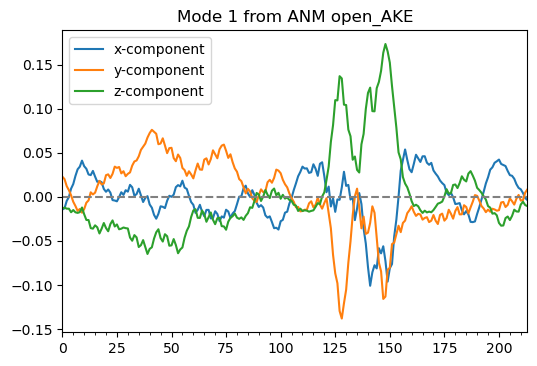

In [9]:
figure(dpi=100)
showMode(anm_open[0]);
legend();

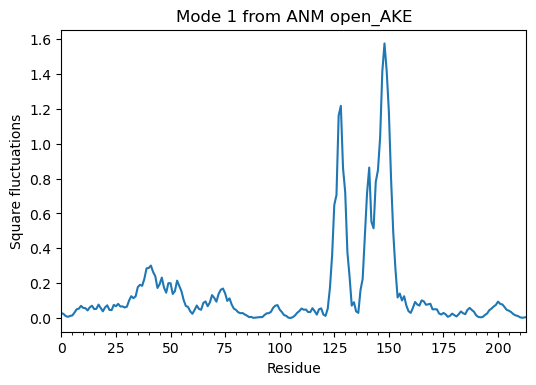

In [10]:
figure(dpi=100)
showSqFlucts(anm_open[0]);

If we want to calculate mean square fluctuations using computed modes, then we do not need to select any specific mode.

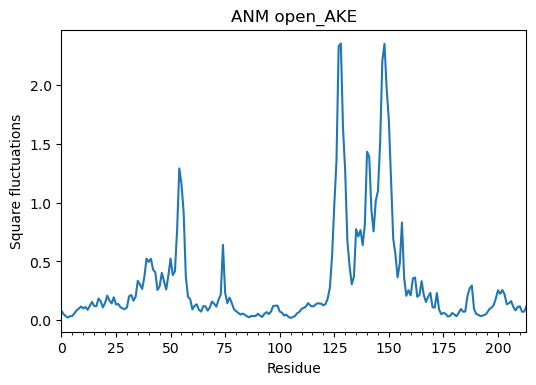

In [11]:
figure(dpi=100)
showSqFlucts(anm_open);   # MSFs based on "computed modes"

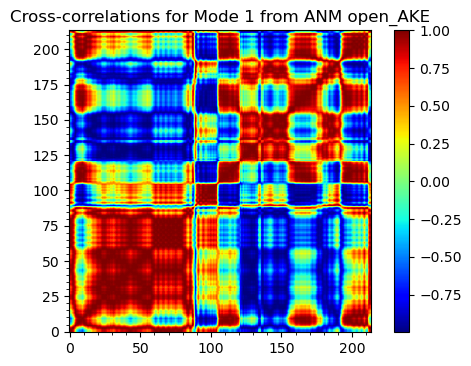

In [12]:
figure(dpi=100)
showCrossCorr(anm_open[0]);

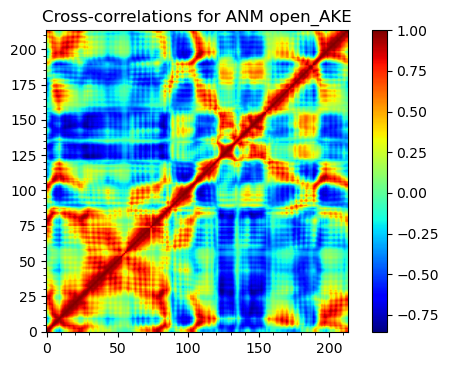

In [13]:
# cross-correlation based on "computed modes"

figure(dpi=100)
showCrossCorr(anm_open);

In order to visualize ANM modes in NMWiz, we need to write them into a .nmd file using `writeNMD`.

In [14]:
writeNMD('anm_open_ake', anm_open, open_ca)

'anm_open_ake'

## Visualization of the structures in VMD

First we will align the open and closed structures before visualizing them together in VMD. Since the chains of these two structures match, we do not need to find the mathcing atoms in these chains. Let's first look at the RMSD  between the resolved structures. 

In [15]:
calcRMSD(closed_ca, open_ca)

75.04657622215835

Alignment of the closed structure onto the open one can be easily done using the function `superpose` :

In [16]:
aligned_closed_ca, T = superpose(closed_ca, open_ca)

RMSD between these structures is minimized after this alignment as we will see below:

In [17]:
calcRMSD(aligned_closed_ca, open_ca)

7.130700152775837

In [18]:
writePDB('1akeA_ca_alg.pdb', aligned_closed_ca)

'1akeA_ca_alg.pdb'

In [19]:
writePDB('4akeA_ca.pdb', open_ca)

'4akeA_ca.pdb'

We can now run VMD from jupyter notebook using an exclamation mark to tell the jupyter notebook that it is a command run by the operating system not by the python kernel.

## Deformation analysis and the comparison with ANM modes

We can easily calculate the deformation vector describing the change between two structures of the protein AKE, and then systematically compare it with ANM modes. Because the chains of these structures match and we have already aligned them, it is straightforward to calculate the deformation vector using `calcDeformVector` .

In [20]:
defvec = calcDeformVector(open_ca, aligned_closed_ca)

We then show the overlap or correlation cosine between the ANM modes and the deformation vector. The cumulative overlap is the square root of the sum of squared overlaps.

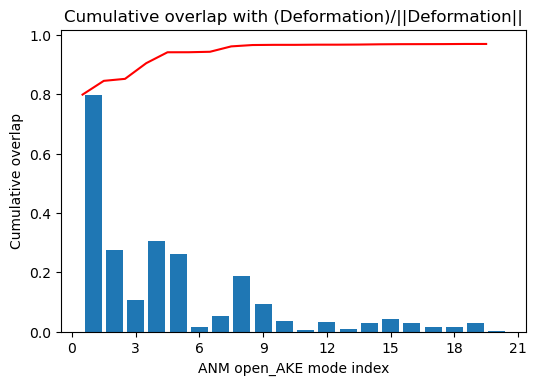

In [21]:
figure(dpi=100)
showOverlap(defvec.getNormed(), anm_open)
showCumulOverlap(defvec.getNormed(), anm_open, 'r');

We observe that the first nonzero mode in the above figure, **whose index is 0**, overlaps best with the transition described by the deformation vector. Therefore, we can use this mode to generate a trajectory by the method `traverseMode`. This takes steps in both directions starting from the provided structure to generate conformers along the mode chosen.

Let's first generate a trajectory along this mode based on $C^\alpha$ atoms, and then calculate RMSD between the last conformer in the trajectory and the closed structure to see how close we can get to the latter. Remember RMSD between aligned structures is 7.13 $\mathring{A}$.

In [22]:
ca_mode1 = traverseMode(anm_open[0], open_ca, rmsd=5.0)
ca_mode1.setAtoms(open_ca)

@> Parameter: rmsd = 5.00 A
@> Parameter: n_steps = 10
@> Step size is 0.50 A RMSD
@> Mode is scaled by 1.2796916122851876.


In [23]:
calcRMSD(aligned_closed_ca, ca_mode1[-1])

4.3475290961951965

Let's generate a similar trajectory for all atom this time. In order to do that, we can extend $C^\alpha$-based ANM to all atoms by the function `extendModel`. 

In [24]:
aa_anm, aa_atoms = extendModel(anm_open, open_ca, open_aa)

The next step is to use `traverseMode` again to generate conformers along the extended mode. 

In [25]:
aa_mode1 = traverseMode(aa_anm[0], aa_atoms)
aa_mode1.setAtoms(aa_atoms)

@> Parameter: rmsd = 1.50 A
@> Parameter: n_steps = 10
@> Step size is 0.15 A RMSD
@> Mode is scaled by 1.067949380950183.


In [26]:
writePDB('4ake_all_atom_mode1.pdb', aa_mode1)

'4ake_all_atom_mode1.pdb'

In [27]:
writeNMD('4ake_all_atom_anm', aa_anm, aa_atoms)

'4ake_all_atom_anm'

We can now visualize both in VMD.